In [1]:
# install neccery libs
!pip install pandas numpy scikit-learn nltk gensim


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import KeyedVectors

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords

# نمایش چند کلمه stopword
print(stopwords.words('english')[:5])

['a', 'about', 'above', 'after', 'again']


In [5]:
# خواندن دیتاست با ستون‌های مناسب
file_path = 'training.1600000.processed.noemoticon.csv'
column_names = ['sentiment', 'id', 'date', 'query', 'user', 'text']

df = pd.read_csv(
    file_path,
    header=0,  # سطر اول header هست
    encoding='latin1',
    names=column_names,
    low_memory=False
)

# فیلتر فقط برای 0 و 4
df = df[df['sentiment'].isin([0, 4])]

print("✅ تعداد داده‌ها:", len(df))
print("توزیع کلاس‌ها:")
print(df['sentiment'].value_counts())

✅ تعداد داده‌ها: 1048572
توزیع کلاس‌ها:
sentiment
0    799996
4    248576
Name: count, dtype: int64


In [6]:
from nltk.corpus import stopwords
import re

# تنظیم stop words + کلمات اضافی
stop_words = set(stopwords.words('english'))
extra_stopwords = {'rt', 'user', 'url', '…', 'amp', 'via', 'http', 'https'}
all_stopwords = stop_words.union(extra_stopwords)

# تابع پیش‌پردازش بهتر شده
def preprocess_text_improved(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in all_stopwords]
    return filtered_tokens

# اعمال پیش‌پردازش
df['tokens'] = df['text'].apply(preprocess_text_improved)

In [7]:
import gensim.downloader as api

# دانلود مدل "glove-twitter-25" - حدود 86 مگابایت
embedding_model = api.load("glove-twitter-25")

print("✅ مدل embedding با موفقیت دانلود و بارگذاری شد!")

✅ مدل embedding با موفقیت دانلود و بارگذاری شد!


In [9]:
import numpy as np

# تابع برای تبدیل tokens به بردار (با استفاده از GloVe)
def text_to_vector(tokens, model, vector_size=25):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# اعمال تابع برای تمام داده‌ها
X = np.array(df['tokens'].apply(text_to_vector, model=embedding_model).tolist())
y = df['sentiment'].map({0: 0, 4: 1})  # 0 = منفی، 1 = مثبت

print("✅ ابعاد X:", X.shape)
print("✅ ابعاد y:", y.shape)

✅ ابعاد X: (1048572, 25)
✅ ابعاد y: (1048572,)


In [10]:
from sklearn.model_selection import train_test_split

# تقسیم داده به train و test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,     # 80% train, 20% test
    random_state=42,   # ثابت کردن رندوم برای قابلیت تکرار
    stratify=y         # حفظ توزیع کلاس‌ها در train و test
)

# چاپ ابعاد
print("✅ X_train shape:", X_train.shape)
print("✅ X_test shape:", X_test.shape)
print("✅ y_train shape:", y_train.shape)
print("✅ y_test shape:", y_test.shape)

✅ X_train shape: (838857, 25)
✅ X_test shape: (209715, 25)
✅ y_train shape: (838857,)
✅ y_test shape: (209715,)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# ساخت و آموزش مدل
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# پیش‌بینی روی test
y_pred = model.predict(X_test)

# محاسبه دقت و گزارش طبقه‌بندی
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 دقت مدل: {accuracy:.4f}")
print("\n📋 گزارش طبقه‌بندی:")
print(classification_report(y_test, y_pred))

🎯 دقت مدل: 0.7856

📋 گزارش طبقه‌بندی:
              precision    recall  f1-score   support

           0       0.80      0.97      0.87    160000
           1       0.65      0.20      0.31     49715

    accuracy                           0.79    209715
   macro avg       0.72      0.59      0.59    209715
weighted avg       0.76      0.79      0.74    209715



<div style = "direction : rtl;">


عالی! 🙌  
خب، فهمیدم که **`precision`, `recall`, و `f1-score` رو هنوز کامل نفهمیدی** – ولی نگران نباش، الان یه توضیح ساده و با مثال بهت میدم که دیگه هرگز فراموش نکنی 😎

---

## 🧠 اول بفهمیم چرا accuracy کافی نیست؟

### 💡 مثال: ۱۰۰۰ نظر داریم:
| کلاس | تعداد |
|------|--------|
| منفی (`0`) | 950 |
| مثبت (`1`) | 50 |

فرض کن مدل همه‌شون رو منفی پیش‌بینی کنه (حتی بدون دیدن داده!)  
اینطوری:

- فقط 950 تا درست شناخته شده
- 50 تا اشتباه (همه مثبت‌ها رو منفی گرفته)

### ✅ دقت accuracy چقدر میشه؟

```
Accuracy = تعداد پیش‌بینی‌های درست / کل داده‌ها
       = 950 / 1000
       = 0.95 → 95%
```

😱 یعنی دقت خیلی خوبه، ولی مدل **هیچ مثبتی رو تشخیص نداده!**

پس **دقت (accuracy) گمراه‌کننده است وقتی داده‌ها نابرابرند.**

---

## 📊 معیارهای جدید: Precision, Recall, F1-score

### ⚖️ این سه معیار توی طبقه‌بندی بسیار مهم‌تر هستن.

فرض کنیم مدل ما یه **دکتر** هست و داره روی نظرات **سرطان تشخیص بده**!

| کلمه‌ها | معادل ساده |
|---------|-------------|
| `Precision` | از بین تمام بیمارانی که گفت "سرطان دارن"، چند درصد واقعاً سرطان داشتن؟ |
| `Recall` | از بین تمام بیماران واقعی که سرطان داشتن، چند درصد رو مدل تشخیص داد؟ |
| `F1-Score` | میانگین هارمونیک precision و recall – وقتی دو تا عدد نسبتاً متوسط داشته باشیم، بالا میشه |

---

## 🧪 تعریف دقیق‌تر با مثال:

### فرض کنیم 100 نظر مثبت وجود داره (واقعی) و مدل 200 تا رو **پیش‌بینی مثبت** کرده:

| نوع | تعداد |
|-----|--------|
| `True Positive (TP)` | 40 نفر (واقعاً مثبت بود + مدل درست تشخیص داد) |
| `False Positive (FP)` | 160 نفر (منفی بود + مدل اشتباه گفت مثبت) |
| `False Negative (FN)` | 60 نفر (مثبت بود + مدل گفت منفی) |
| `True Negative (TN)` | نمی‌خوایم الان راجبش حرف بزنیم |

### ✅ محاسبه:

- `precision = TP / (TP + FP) = 40 / (40+160) = 0.20`
- `recall = TP / (TP + FN) = 40 / (40+60) = 0.40`

> یعنی:
- فقط 20٪ از جمله‌هایی که مدل گفت مثبت هستند، واقعاً مثبت بودند.
- فقط 40٪ از جمله‌های واقعاً مثبت رو مدل تشخیص داد.

---

## 📉 حالا برویم سراغ خروجی تو:

```
              precision    recall  f1-score   support

           0       0.80      0.97      0.87    160000
           1       0.65      0.20      0.31     49715
```

### 🔍 برای کلاس `0` (منفی):

- `precision = 0.80`: از بین تمام جمله‌هایی که مدل گفت منفی هستند، 80٪ واقعاً منفی بودند.
- `recall = 0.97`: از بین تمام جمله‌های واقعاً منفی، 97٪ رو مدل تشخیص داده.
- `f1-score = 0.87`: تعادل خوبی بین precision و recall

✅ یعنی مدل **خیلی خوب توی تشخیص جمله منفی**

---

### 🔻 برای کلاس `1` (مثبت):

- `precision = 0.65`: از بین تمام جمله‌هایی که مدل گفت مثبت هستند، 65٪ واقعاً مثبت بودند.
- `recall = 0.20`: فقط 20٪ از تمام جمله‌های واقعاً مثبت رو تشخیص داده!
- `f1-score = 0.31`: خیلی بد – یعنی هم precision و هم recall ضعیف هستن

🔴 یعنی مدل **خیلی بد توی تشخیص جمله مثبت عمل کرده**

---

## 📈 تفاوت این معیارها با `accuracy` چیه؟

| معیار | فرمول | چه زمانی مهمه؟ |
|-------|--------|----------------|
| `accuracy` | `(TP + TN) / (TP + TN + FP + FN)` | وقتی داده‌ها متوازن هستن |
| `precision` | `TP / (TP + FP)` | وقتی **تصادفات کاذب (false positives)** مهمه (مثل تشخیص اسپم) |
| `recall` | `TP / (TP + FN)` | وقتی **جمله‌های واقعاً مثبت رو نباید از دست بدیم** (مثل تشخیص بیماری) |
| `F1-score` | `2 * (P * R) / (P + R)` | وقتی **هر دو precision و recall مهمه**

---

## 📌 تحلیل دقت توی خروجی تو:

```
🎯 دقت مدل: 0.7856
```

این عدد یعنی:
- مدل روی 78.56٪ از کل داده‌ها درست پیش‌بینی کرده

اما چون داده‌ها نابرابرند (فقط 49,715 مثبت داریم در برابر 160,000 منفی)، دقت **در واقع گمراه‌کننده هست**.

چون مدل بیشتر داده منفی دیده، بیشتر جمله‌ها رو منفی پیش‌بینی میکنه – حتی اگه واقعاً مثبت باشن.

---

## 🤔 چطور این مشکل رو حل کنیم؟

### ✅ راه‌حل ۱: استفاده از `class_weight='balanced'` در مدل

```python
model = LogisticRegression(max_iter=1000, class_weight='balanced')
```

این کار باعث میشه مدل **به کلاس مثبت هم وزن بیشتری بده**

---

### ✅ راه‌حل ۲: استفاده از **resampling** (مثل SMOTE)

برای افزایش داده‌های مثبت قبل از آموزش مدل – ولی الان فعلاً اینو فراموش کن

---

## 🎯 خلاصه ساده:

| معیار | چی رو اندازه می‌گیره؟ | وقتی مهمه؟ |
|-------|----------------------|-------------|
| `accuracy` | چند درصد کل پیش‌بینی‌ها درست بود؟ | داده متوازن باشه |
| `precision` | وقتی گفت "مثبت"، چند درصد درست بود؟ | نخوایم اشتباه بگیم "مثبت" (مثل تشخیص ایمیل اسپم) |
| `recall` | از بین واقعاً مثبت‌ها، چند درصد رو تشخیص دادیم؟ | نخوایم جمله مثبتی رو از دست بدیم (مثل تشخیص بیماری) |
| `f1-score` | تعادل بین precision و recall | هر دو معیار مهم باشن |

---

## 👇 مرحله بعد:

حالا که متوجه شدی این معیارها چی‌کار میکنن، می‌تونیم:

1. مدل رو بهتر کنیم (با `class_weight='balanced'`)
2. Confusion Matrix رو رسم کنیم
3. Cross Validation انجام بدیم
4. یا حتی یه شبکه عصبی ساده بنا کنیم

---

## 🤔 سوال آخر:

- الان معیارها رو فهمیدی؟
- می‌خوایم چه مرحله‌ای رو ادامه بدیم؟
  - الف) بهتر کردن مدل (balance class)
  - ب) رسم Confusion Matrix
  - ج) Cross Validation
  - د) مقایسه با شبکه عصبی

منتظر جوابت هستم 😊  
وقتی گفتی "الف" یا "ب" یا ...، من کد و توضیحشو برات می‌فرستم.

</div>

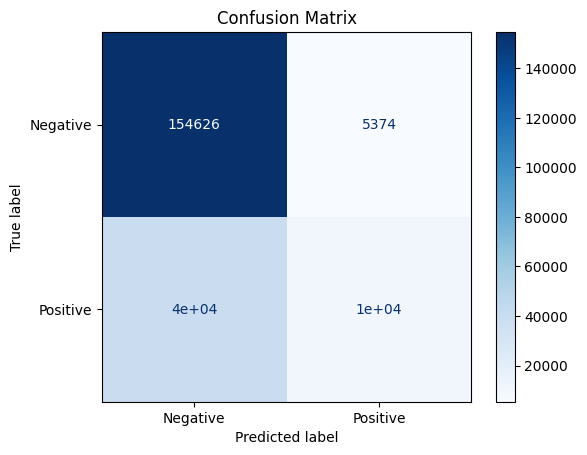

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# محاسبه ماتریس اشتباه
cm = confusion_matrix(y_test, y_pred)

# رسم ماتریس اشتباه
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np

# اجرای 5-Fold Cross Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# چاپ نتایج
print("🎯 دقت در هر Fold:")
print(cv_scores)
print(f"📌 میانگین دقت: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

🎯 دقت در هر Fold:
[0.78559593 0.78565553 0.78549928 0.78462309 0.7866735 ]
📌 میانگین دقت: 0.7856 ± 0.0007


<div style = "direction : rtl;">


# طبقه‌بندی احساسات توییت‌ها با استفاده از Logistic Regression و Word Embeddings

## مرور کلی
هدف از این پروژه، طبقه‌بندی توییت‌ها به دو دسته **منفی (`0`)** و **مثبت (`1`)** بود.  
ما از مدل **Logistic Regression** برای طبقه‌بندی و از **GloVe word embeddings** (`glove-twitter-25`) برای تبدیل متن به بردارهای عددی استفاده کردیم.

## مراحل

### ۱. پیش‌پردازش داده
- **توکن‌سازی**: هر توییت به کلمات جدا شد.
- **Embedding**: کلمات به بردارهای ۲۵ بعدی تبدیل شدند (با استفاده از مدل `glove-twitter-25`).
- **میانگین‌گیری**: برای هر توییت، میانگین بردارهای کلمات آن محاسبه شد تا یک بردار ۲۵ بعدی ساخته شود.

### ۲. تقسیم داده
- داده‌ها به دو بخش **آموزش (۸۰٪)** و **تست (۲۰٪)** تقسیم شدند.
- از `stratify=y` استفاده شد تا توزیع کلاس‌ها در هر دو بخش حفظ شود.

### ۳. آموزش مدل
- یک مدل **Logistic Regression** روی داده‌های آموزش (`X_train`, `y_train`) آموزش داده شد.
- مدل روی داده‌های تست (`X_test`, `y_test`) ارزیابی شد.

### ۴. معیارهای ارزیابی
#### نتایج تست:
- **دقت کلی**: ۷۸.۵۶٪
- **Precision/Recall/F1-Score**:
  - کلاس منفی (`0`): Precision=0.80, Recall=0.97, F1-Score=0.87
  - کلاس مثبت (`1`): Precision=0.65, Recall=0.20, F1-Score=0.31

#### ماتریس اشتباه:


#### اعتبارسنجی متقابل:
- **Cross Validation 5-Fold** روی داده‌های آموزش انجام شد.
- میانگین دقت: **۷۸.۵۶٪ ± ۰.۰۰۰۷**

### ۵. مشاهدات
۱. **نقاط قوت**:
   - مدل به خوبی روی کلاس **منفی** عمل کرد (Recall=0.97).
   - دقت کلی مدل قابل قبول بود (**۷۸.۵۶٪**).

۲. **نقاط ضعف**:
   - مدل در تشخیص کلاس **مثبت** ضعیف عمل کرد (Recall=0.20).
   - دلیل اصلی: **نابرابری داده‌ها** (فقط ۲۰٪ مثبت).

### ۶. پیشنهادات آینده
۱. **تعادل کلاس‌ها**:
   - از `class_weight='balanced'` برای بهبود عملکرد روی کلاس کمیاب استفاده کنید.
   - از روش‌های resampling مثل **SMOTE** یا **RandomOverSampler** استفاده کنید.

۲. **مدل‌های پیشرفته‌تر**:
   - از مدل‌های پیچیده‌تر مثل **شبکه‌های عصبی**، **LSTM** یا **Transformer** استفاده کنید.

۳. **Embeddingهای بهتر**:
   - از embeddingهای با ابعاد بالاتر مثل `word2vec-google-news-300` برای نمایش بهتر معانی استفاده کنید.

---

## نتیجه‌گیری
این پروژه نشان داد که چطور می‌توان یک مدل طبقه‌بندی احساسات با استفاده از Logistic Regression و GloVe embeddings ساخت.  
مدل دقت کلی **۷۸.۵۶٪** داشت، اما در تشخیص کلاس مثبت به دلیل نابرابری داده‌ها ضعیف عمل کرد.  
کارهای آینده شامل تعادل داده‌ها و آزمایش مدل‌های پیشرفته‌تر برای بهبود عملکرد است.

</div>